In [ ]:
# default_exp models.nbeats

In [ ]:
# hide
import sys

sys.path.append("..")

# N-Beats model

> A basic architecture for time series forecasting.


In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.callback.hook import num_features_model
from fastai2.callback.all import *

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# export


class Block(nn.Module):
    def __init__(
        self,
        units,
        thetas_dim,
        device,
        backcast_length=10,
        forecast_length=5,
        share_thetas=False,
    ):
        super(Block, self).__init__()
        self.units = units
        self.thetas_dim = thetas_dim
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.share_thetas = share_thetas
        self.fc1 = nn.Linear(backcast_length, units)
        self.fc2 = nn.Linear(units, units)
        self.fc3 = nn.Linear(units, units)
        self.fc4 = nn.Linear(units, units)
        self.device = device
        self.backcast_linspace, self.forecast_linspace = linspace(
            backcast_length, forecast_length
        )
        if share_thetas:
            self.theta_f_fc = self.theta_b_fc = nn.Linear(units, thetas_dim)
        else:
            self.theta_b_fc = nn.Linear(units, thetas_dim)
            self.theta_f_fc = nn.Linear(units, thetas_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x.to(self.device)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

    def __str__(self):
        block_type = type(self).__name__
        return (
            f"{block_type}(units={self.units}, thetas_dim={self.thetas_dim}, "
            f"backcast_length={self.backcast_length}, forecast_length={self.forecast_length}, "
            f"share_thetas={self.share_thetas}) at @{id(self)}"
        )


In [ ]:
# export
class GenericBlock(Block):
    def __init__(
        self, units, thetas_dim, device, backcast_length=10, forecast_length=5
    ):
        super(GenericBlock, self).__init__(
            units, thetas_dim, device, backcast_length, forecast_length
        )

        self.backcast_fc = nn.Linear(thetas_dim, backcast_length)
        self.forecast_fc = nn.Linear(thetas_dim, forecast_length)

    def forward(self, x):
        # no constraint for generic arch.
        x = super(GenericBlock, self).forward(x)

        theta_b = F.relu(self.theta_b_fc(x))
        theta_f = F.relu(self.theta_f_fc(x))

        backcast = self.backcast_fc(theta_b)  # generic. 3.3.
        forecast = self.forecast_fc(theta_f)  # generic. 3.3.

        return backcast, forecast


In [ ]:
# export

class SeasonalityBlock(Block):
    def __init__(
        self, units, thetas_dim, device, backcast_length=10, forecast_length=5
    ):
        super(SeasonalityBlock, self).__init__(
            units,
            thetas_dim,
            device,
            backcast_length,
            forecast_length,
            share_thetas=True,
        )

    def forward(self, x):
        x = super(SeasonalityBlock, self).forward(x)
        backcast = seasonality_model(
            self.theta_b_fc(x), self.backcast_linspace, self.device
        )
        forecast = seasonality_model(
            self.theta_f_fc(x), self.forecast_linspace, self.device
        )
        return backcast, forecast

In [ ]:
# export
class TrendBlock(Block):
    def __init__(
        self, units, thetas_dim, device, backcast_length=10, forecast_length=5
    ):
        super(TrendBlock, self).__init__(
            units,
            thetas_dim,
            device,
            backcast_length,
            forecast_length,
            share_thetas=True,
        )

    def forward(self, x):
        x = super(TrendBlock, self).forward(x)
        backcast = trend_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = trend_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast

In [ ]:
# export
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F


class NBeatsNet(nn.Module):
    SEASONALITY_BLOCK = "seasonality"
    TREND_BLOCK = "trend"
    GENERIC_BLOCK = "generic"

    def __init__(
        self,
        device,
        stack_types=(TREND_BLOCK, SEASONALITY_BLOCK),
        nb_blocks_per_stack=3,
        forecast_length=5,
        backcast_length=10,
        thetas_dims=(4, 8),
        share_weights_in_stack=False,
        hidden_layer_units=256,
    ):
        super(NBeatsNet, self).__init__()
        self.forecast_length = forecast_length
        self.backcast_length = backcast_length
        self.hidden_layer_units = hidden_layer_units
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.share_weights_in_stack = share_weights_in_stack
        self.stack_types = stack_types
        self.stacks = []
        self.thetas_dim = thetas_dims
        self.parameters = []
        self.device = device
        print(f"| N-Beats")
        for stack_id in range(len(self.stack_types)):
            self.stacks.append(self.create_stack(stack_id))
        self.parameters = nn.ParameterList(self.parameters)
        self.to(self.device)

    def create_stack(self, stack_id):
        stack_type = self.stack_types[stack_id]
        print(
            f"| --  Stack {stack_type.title()} (#{stack_id}) (share_weights_in_stack={self.share_weights_in_stack})"
        )
        blocks = []
        for block_id in range(self.nb_blocks_per_stack):
            block_init = NBeatsNet.select_block(stack_type)
            if self.share_weights_in_stack and block_id != 0:
                block = blocks[-1]  # pick up the last one when we share weights.
            else:
                block = block_init(
                    self.hidden_layer_units,
                    self.thetas_dim[stack_id],
                    self.device,
                    self.backcast_length,
                    self.forecast_length,
                )
                self.parameters.extend(block.parameters())
            print(f"     | -- {block}")
            blocks.append(block)
        return blocks

    @staticmethod
    def select_block(block_type):
        if block_type == NBeatsNet.SEASONALITY_BLOCK:
            return SeasonalityBlock
        elif block_type == NBeatsNet.TREND_BLOCK:
            return TrendBlock
        else:
            return GenericBlock

    def forward(self, backcast):
        forecast = torch.zeros(
            size=(backcast.size()[0], self.forecast_length,)
        )  # maybe batch size here.
        for stack_id in range(len(self.stacks)):
            for block_id in range(len(self.stacks[stack_id])):
                b, f = self.stacks[stack_id][block_id](backcast)
                backcast = backcast.to(self.device) - b
                forecast = forecast.to(self.device) + f
        return backcast, forecast


def seasonality_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p < 10, "thetas_dim is too big."
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    s1 = torch.tensor([np.cos(2 * np.pi * i * t) for i in range(p1)]).float()  # H/2-1
    s2 = torch.tensor([np.sin(2 * np.pi * i * t) for i in range(p2)]).float()
    S = torch.cat([s1, s2])
    return thetas.mm(S.to(device))


def trend_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= 4, "thetas_dim is too big."
    T = torch.tensor([t ** i for i in range(p)]).float()
    return thetas.mm(T.to(device))


def linspace(backcast_length, forecast_length):
    lin_space = np.linspace(
        -backcast_length, forecast_length, backcast_length + forecast_length
    )
    b_ls = lin_space[:backcast_length]
    f_ls = lin_space[backcast_length:]
    return b_ls, f_ls


In [ ]:

# from fastai2.basics import *
# from fastseq.all import *

# @delegates(DNN.__init__)
# def dnn_learner(dbunch, output_channels=None, metrics=None, **kwargs):
#     "Build a dnn style learner"
#     output_channels = ifnone(output_channels,dbunch.train[0][0].shape[0])
    
#     model = DNN(input_channels=dbunch.train[0][0].shape[0],
#         output_channels=output_channels, 
#         horizon = dbunch.train_dl.horizon,
#         lookback = dbunch.train_dl.lookback, 
#         **kwargs
#        )
    
#     learn = Learner(dbunch, model, loss_func=F.mse_loss, opt_func= Adam, metrics=L(metrics)+L(mae, smape))
#     return learn

NameError: name 'DNN' is not defined

In [ ]:


path = untar_data(URLs.m4_daily)
data = TSDataBunch.from_folder(path, horizon = 14, lookback = 128, bs = 64, nrows=100)
learn = dnn_learner(data)

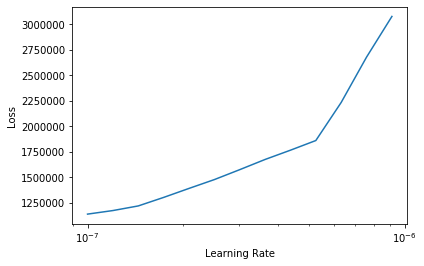

In [ ]:
from fastai2.callback.all import *
learn.lr_find()

In [ ]:
learn.fit(2,1e-7)

epoch,train_loss,valid_loss,mae,smape,time
0,17949792.000000,24617872.000000,3964.405762,199.698914,00:16
1,17949766.000000,24614758.000000,3964.385010,199.724121,00:15


In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 03_data.load.ipynb.
Converted 04_data.transforms.ipynb.
Converted 05_models.wavenet.ipynb.
Converted 06_models.dnn.ipynb.
Converted 08_metrics.ipynb.
Converted 09_learner.ipynb.
Converted 20_models.cnn.learner.ipynb.
Converted 21_models.cnn.transforms.ipynb.
Converted index.ipynb.
